In [90]:
%load_ext autoreload
%autoreload 2
import geopandas as gpd
directory = '/scratch/6256481/'


import sys
sys.path.insert(0, directory + f'python/py_code/')
import numpy as np
from support import get_local_utm_projection, node_position, adjust_new_segments
from cycle_identification import find_connected_side
from get_orthogonals import get_orthogonals
from dem import find_dem

from shapely.geometry import Point, LineString

from support import create_dir
from glob import glob
# from python.py_code.old.remove_mannual_add import remove_manual_add, remove_man_add

from line_functions import get_bend_dist_out


import pandas as pd
# from python.py_code.old.reach_def import create_ud_id, create_new_segments

from datetime import datetime as dt
from inflection_points import inflection_points, inflection_points_curve


from connect_geometries import merge_centerlines
from smoothing import SG_smoothing
from tqdm import tqdm

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import xarray as xr
import shapely


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
singleConfFiles = np.sort(glob(directory + f'results/single_values/*conf.nc'))

In [92]:
c = 'as'
i = '12'

create_new = False
vector_save_file = directory +f'results/new_segments/vector/{c}_{i}_reach_new_segments.gpkg'
node_save_file   = directory +f'results/new_segments/node/{c}_{i}_node_new_segments.gpkg' 

In [ ]:
df       = gpd.read_file(vector_save_file)
dfNode   = gpd.read_file(node_save_file)

df = adjust_new_segments(df)

In [ ]:
dfCF = pd.read_csv(directory + 'results/confinement_factor.csv')

In [ ]:
dftest  = gpd.read_file(glob.glob(directory + 'input/SWOT_vector/af*.gpkg')[0])
dfNtest = gpd.read_file(glob.glob(directory + 'input/SWOT_nodes/af*.gpkg')[0])

In [ ]:
# files = np.sort(glob.glob(directory +f'results/new_segments/vector/??_??_*.gpkg'))

# for i, f in enumerate(files):
#     D = gpd.read_file(f)
#     D['file_cont'] = f[-29:-27]
#     D['file_id']   = f[-26:-24]
    
#     if i == 0:
#         dfT = D.copy()
#     else:
#         dfT = pd.concat([dfT, D], ignore_index = True)
# dfT['file'] = dfT['file_cont'] +'_'+ dfT['file_id']
# dfInc = dfT[dfT['include_flag'] == '0']

In [ ]:
def plot(combinedLine, combinedLineSmooth, infP, infPTotal,apexP, apexPO):
    f, ax = plt.subplots(nrows=1, ncols=1, figsize = [10,6], sharey=True)

    ax.plot(*combinedLine.xy      , color = 'orange'   , zorder = 0)
    ax.plot(*combinedLineSmooth.xy, color = 'chocolate', zorder = 10, linestyle = '--')

    # plot inflections
    if isinstance(infP, list):
        for i, ip in enumerate(infP):
            plt.scatter(*ip.xy, zorder = 100, c = 'black', marker = '.')
        for i, ip in enumerate(infPTotal):
            plt.scatter(*ip.xy, zorder = 80, c = 'lime', marker = '.')
    if isinstance(apexP, list):
        for i, ap in enumerate(apexP):
            plt.scatter(*ap.xy, zorder = 100, c = 'red', marker = '^')
            plt.scatter(*apexPO[i].xy, zorder = 100, c = 'red', marker = '1')
            

    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')



    plt.tight_layout()
    plt.show()

def plot_inflection_points_curve(inf, infT, apexP, apexPO, line, lineO):
    plt.figure(figsize=[10,8])
        # plt.scatter(*testApex, label = arcSign[ip], marker = '^', s = 25, zorder = 200, c = 'green')
    # for i in range(len(apexP)):
    #     plt.scatter(*apexP[i].xy , s = 30, marker = 'h', zorder = 150, c = 'red')
    #     plt.scatter(*apexPO[i].xy, s = 30, marker = '1', zorder = 100, c = 'red')

    for i in range(len(inf)):
        plt.scatter(*inf[i]    , s = 30, marker = '.', zorder = 100, c = 'limegreen')
        # plt.scatter(*inf[i]    , s = 20, marker = '.', zorder = 100, label = i) 
    plt.scatter(*inf[i]    , s = 100, marker = '.', zorder = 100, c = 'limegreen')

    for i,p in enumerate(infT):
        plt.scatter(*p    , s = 30, marker = '.', zorder = 50, c = 'black')

    plt.plot(*line.xy , zorder = 10, color = 'blue', linestyle = '--')
    plt.plot(*lineO.xy, zorder = 5 , color = 'cyan', linestyle = '-')
    plt.axis('equal')
    plt.axis('off')
    # plt.legend()
    plt.show()


In [ ]:
int(df[df['reach_id'] == 45254000021]['combined_reach_id'].iloc[0])
# df.iloc[0:10].combined_reach_id.values

48173

In [ ]:
df[df['combined_reach_id'] == 48126]['reach_id'].values
ids = df.loc[df['include_flag'] == '0','combined_reach_id'].unique()
ids[0:20]

array([ 0.,  1.,  2.,  7.,  6.,  5.,  4.,  3., 26., 25., 24., 23., 22.,
       21., 20., 19., 18., 17., 16., 15.])

  0%|          | 0/3 [00:00<?, ?it/s]

48120 [45253000241 45253000251 45253000261 45253000271 45253000281 45253000291]
[1061  683  899 1571    0]
[2600.91578947 1666.44186047 1760.16153846 2536.03333333   95.38898517]


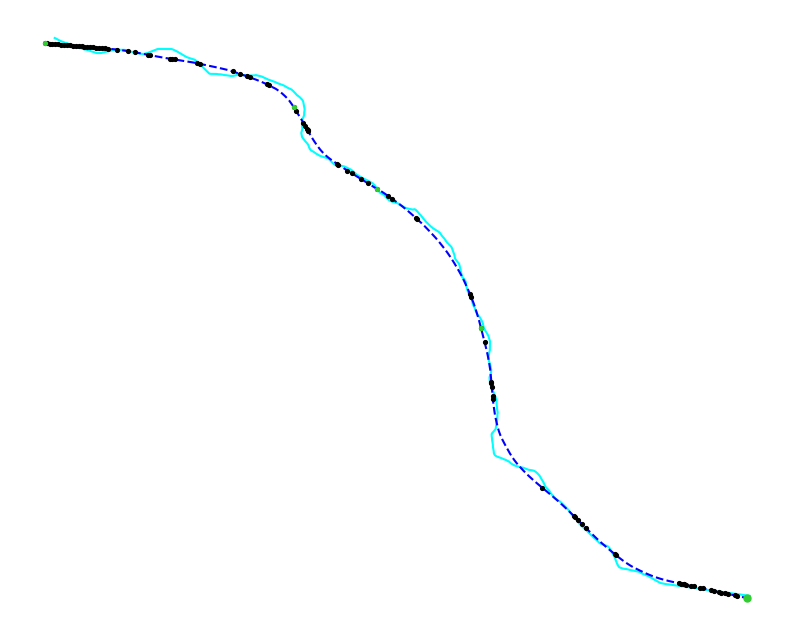

 33%|███▎      | 1/3 [00:02<00:05,  2.56s/it]

70721.80170928055 [19044.71445476  8600.21505614 12912.96617188 30163.90602649]
48119 [45253000301 45253000361 45253000321 45253000331 45253000341 45253000351
 45253000371 45253000381 45253000391 45253000401 45253000411 45253000421
 45253000431 45253000444 45253000451 45253000461 45253000474]
[  68  109  852 1115  733  930    0]
[  68.95652174  410.64516129 3990.08027523 2262.42982456 3145.40926641
 1757.04263566   36.81152428]


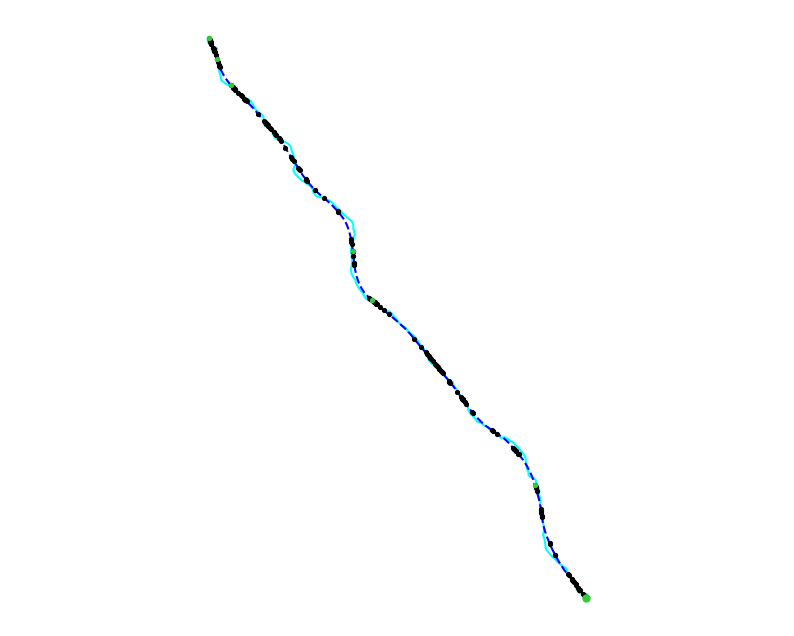

 67%|██████▋   | 2/3 [00:09<00:05,  5.13s/it]

143717.85001436347 [ 4624.77023238  6160.91340858 43637.86486584 11244.27535271
 51932.71498696 26117.31116789]
48173 [45254000021 45254000031 45254000041 45254000051 45254000061 45254000071]
[ 569    0  787  784 2798]
[1280.28985507  338.2467977  1388.06666667 1930.47540984 7446.65986395]


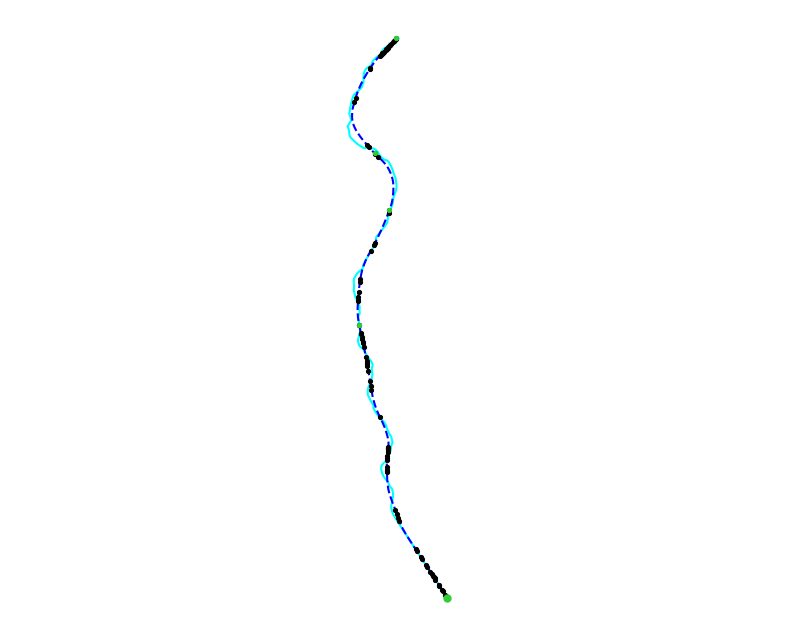

100%|██████████| 3/3 [00:11<00:00,  3.99s/it]

61895.77417375044 [13720.84471857  5904.85540597 12174.5998718  29578.28240295]


In [ ]:
minLenFactor = 4*12

ids = df.loc[df['include_flag'] == '0','combined_reach_id'].unique()

# ids = [622,621, 677, 625, 545, 491, 492,494]
ids = [625, 545] # contains short straight sections (eu - 00)

ids = [625, 545, 0.,  1.,  2.,  7.,  6.,  5.,  4.,  3., 26., 25., 24., 23., 22.,
       21., 20., 19., 18., 17., 16., 15.]
ids = [48120, 48119, 48173, 35504, 36312, 34818, 35551] #[45588]

dfSF = pd.read_csv(directory + 'results/smoothingFactor.csv')

for id in tqdm(ids):
        
        dfReach      = df[df['combined_reach_id'] == id].copy()
        dfReachNodes = dfNode[dfNode['reach_id'].isin(dfReach['reach_id'].values)].copy()
        print(id, dfReach.reach_id.values)

        dfReach.loc[dfReach['max_width'] < dfReach['width'], 'max_width']                = dfReach['width']
        dfReachNodes.loc[dfReachNodes['max_width'] < dfReachNodes['width'], 'max_width'] = dfReachNodes['width']

        GroupedCRS = dfReach.groupby('localCRS', as_index = False).size()
        reachCRS   = GroupedCRS.loc[GroupedCRS['size'] == GroupedCRS['size'].max()
                                    ,'localCRS'].iloc[0]
        
        dfReach      = dfReach.to_crs(reachCRS)
        dfReachNodes = dfReachNodes.to_crs(reachCRS)

        combinedLine, _, _ = merge_centerlines(dfReach, df, reachCRS)
        
        dfReachNodes = node_position(combinedLine, dfReachNodes)
        
        groupVals = dfReach.iloc[0]
        maxWidth = groupVals['combined_reach_max_width']
        width    = groupVals['combined_reach_width']
        
        if np.isnan(maxWidth):
                maxWidth = dfReachNodes['max_width'].mean()


        reachLen = groupVals['combined_reach_len']
        
        factorWidth = width
        minLen      = minLenFactor * maxWidth
        ###########################
        # Smoothing
        ###########################
        factorRow       = abs(dfSF['combined_reach_width'] - width).argsort()
        smoothingFactor = dfSF.loc[factorRow, 'smoothFactor'].iloc[0]
        maxWidth = huber_mean(dfReachNodes['max_width'])
        smoothing_window = smoothingFactor*int(maxWidth)         # Smoothing window based on mean node max width

        combinedLineSmooth = SG_smoothing(combinedLine, smoothing_window, maxWidth)

 
        if len(combinedLineSmooth.coords) < 3:
            combinedLineSmooth = combinedLineSmooth.segmentize(400) 

        # dt1 = dt.now()
        # (sin, infP, infPTotal,
        #     apex, apexP,apexPO,
        #     ang, bendLines, bendWidths, bendMaxWidths, bendDO) = inflection_points(combinedLineSmooth, 
        #                                 dfReach, dfReachNodes,
        #                                 reachCRS,
        #                                 degree = 0,
        #                                 end_points = True)  
        # dt2 = dt.now()
        # print('oldMethod: ', dt2 - dt1)
        # checkLines.append(combinedLineSmooth)

        # apex      = np.array2string(apex, separator = ', ')
        # ang       = np.array2string(ang, separator = ', ')

        # apexP_wkt         = str([I.wkt for I in apexP.copy()])
        # infP_wkt          = str([I.wkt for I in infP.copy()])
        # bendLines_wkt     = str([I.wkt for I in bendLines.copy()])
        # bendWidths_str    = np.array2string(bendWidths, separator = ', ')
        # bendMaxWidths_str = np.array2string(bendMaxWidths, separator = ', ')
        # calculated = '0'


        # plot(combinedLine, combinedLineSmooth, infP, infPTotal,apexP, apexPO)
        # print(sin)
        dt1 = dt.now()
        (sin, bendSin,inf, infT, amplitudes, apexPList, apexPOList, curveList, bendLines, 
                infLines,bendWidths, bendMaxWidths, bendDO, bendLen) = inflection_points_curve(combinedLineSmooth, dfReach, dfReachNodes)
        dt2 = dt.now()
        # print('newMethod: ', dt2 - dt1)
        plot_inflection_points_curve(inf,infT, apexPList, apexPOList, combinedLineSmooth, combinedLine)
        print(combinedLineSmooth.length, bendLen)
        # print()
        
        # print(

<Axes: ylabel='Frequency'>

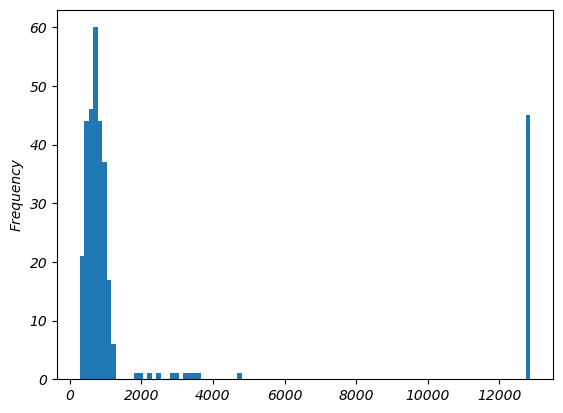

In [ ]:
dfReachNodes['width'].plot.hist(bins = 100)

In [ ]:
dfReachNodes['width'].mean()
dfReachNodes['width'].median()

import numpy as np
from scipy import stats
x = [1, 2, 3, 5]


import numpy as np

def huber_mean(data, max_iter=100, tol=1e-6):
    data = np.asarray(data)
    median = np.median(data)
    mad = np.median(np.abs(data - median))  # Median absolute deviation

    # Set delta to 1.5 * MAD (a common robust default)
    delta = 1.5 * mad if mad > 0 else 1.0

    mu = np.mean(data)  # initial estimate

    for _ in range(max_iter):
        diff = data - mu
        weights = np.where(np.abs(diff) <= delta, 1, delta / np.abs(diff))
        new_mu = np.sum(weights * data) / np.sum(weights)
        if abs(new_mu - mu) < tol:
            break
        mu = new_mu

    return mu

# Example
data = [10, 12, 11, 13, 100]  # 100 is an outlier
print("Huber Mean:", huber_mean(data))

stats.trim_mean(dfReachNodes['width'], 0.05), dfReachNodes['width'].mean(),huber_mean(dfReachNodes['width']), np.median(dfReachNodes['width'])


Huber Mean: 12.00000065480583


(1992.561872909699, 2437.9471299093657, 782.6340094941577, 763.5)